## Setup and Imports

In [ ]:
import sys
import os
import pickle
from typing import Tuple
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D  # Enables 3D plotting in matplotlib
import seaborn as sns
import plotly.express as px

# Add parent directory to path for imports
sys.path.append(os.path.dirname(os.path.abspath('')))

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Load and Prepare Data

In [ ]:
# Load feature vectors
raw_df = pd.read_csv('data/sensor55_feature_vectors.csv')

# Ensure chronological order and proper timestamp type
df = raw_df.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True).dt.tz_localize(None)
df = df.sort_values('timestamp').reset_index(drop=True)

print(f"Loaded {len(df)} feature vectors")
print(f"Features: {df.shape[1]}")
print(f"Time span: {df['timestamp'].min()} → {df['timestamp'].max()}")
print(f"\nFirst few rows:")
df.head()

In [ ]:
# Select relevant features for occupancy modeling (exclude identifiers and metadata)
metadata_cols = ['sensor_id', 'timestamp', 'schema_version']
preferred_features = [
    'co2', 'residual_co2', 'avg_co2_60m', 'std_co2_60m', 'delta_5m_co2', 'delta_30m_co2', 'delta_60m_co2',
    'motion', 'avg_motion', 'max_motion', 'std_motion', 'count_motion_10m', 'count_motion_30m', 'recent_motion_10m',
    'motion_off_hours',
    'light_level', 'light', 'light_recent_motion', 'daylight_factor', 'light_on_at_night',
    'hour_of_day', 'day_of_week', 'is_weekend', 'is_off_hours', 'is_night', 'season'
]

feature_cols = [col for col in preferred_features if col in df.columns]
X = df[feature_cols].values

missing_features = set(preferred_features) - set(feature_cols)
if missing_features:
    print(f"Warning: missing features excluded -> {sorted(missing_features)}")

print(f"Selected {len(feature_cols)} features for modeling")
print(f"Data shape: {X.shape}")
print(f"Example feature list: {feature_cols[:10]} ...")

In [ ]:
# Normalize features for HMM training
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)

print("Features normalized")
print(f"Mean: {X_scaled.mean():.4f}, Std: {X_scaled.std():.4f}")

## HMM Model Selection & Initialization

In [5]:
candidate_states = [3, 4, 5, 6, 7, 8, 9]
stickiness = 0.5
max_iter = 400


def make_sticky_transmat(n_states: int, sticky: float) -> np.ndarray:
    if n_states < 2:
        raise ValueError("Stickiness requires at least 2 states.")
    off_diag = (1.0 - sticky) / (n_states - 1)
    trans = np.full((n_states, n_states), off_diag)
    np.fill_diagonal(trans, sticky)
    return trans


def initialize_emissions_with_kmeans(data: np.ndarray, n_states: int) -> Tuple[np.ndarray, np.ndarray]:
    kmeans = KMeans(n_clusters=n_states, random_state=42, n_init=20)
    kmeans.fit(data)
    means_init = kmeans.cluster_centers_
    covars_init = []
    eps = 1e-3
    for state_idx in range(n_states):
        cluster_points = data[kmeans.labels_ == state_idx]
        if len(cluster_points) == 0:
            covars_init.append(np.full(data.shape[1], eps))
        else:
            covars_init.append(np.clip(cluster_points.var(axis=0), eps, None))
    return means_init, np.vstack(covars_init)


def fit_hmm_with_kmeans(data: np.ndarray, n_states: int, sticky: float, iterations: int) -> GaussianHMM:
    means_init, covars_init = initialize_emissions_with_kmeans(data, n_states)
    model = GaussianHMM(
        n_components=n_states,
        covariance_type='diag',
        n_iter=iterations,
        tol=1e-3,
        random_state=42,
        init_params='',
        params='stmc'
    )
    model.startprob_ = np.full(n_states, 1.0 / n_states)
    model.transmat_ = make_sticky_transmat(n_states, sticky)
    model.means_ = means_init
    model.covars_ = covars_init
    model.fit(data)
    return model


def compute_bic(log_likelihood: float, n_states: int, n_features: int, n_samples: int) -> float:
    n_params = (n_states - 1) + (n_states * (n_states - 1)) + (2 * n_states * n_features)
    return -2 * log_likelihood + n_params * np.log(n_samples)


grid_records = []
models_by_state = {}

for n in candidate_states:
    model = fit_hmm_with_kmeans(X_scaled, n_states=n, sticky=stickiness, iterations=max_iter)
    loglik = model.score(X_scaled)
    bic = compute_bic(loglik, n_states=n, n_features=X_scaled.shape[1], n_samples=len(X_scaled))
    grid_records.append({
        'n_states': n,
        'log_likelihood': loglik,
        'bic': bic,
        'converged': getattr(model.monitor_, 'converged', False)
    })
    models_by_state[n] = model

grid_search_results = pd.DataFrame(grid_records).sort_values('bic').reset_index(drop=True)
best_n_states = int(grid_search_results.loc[0, 'n_states'])

print("Grid search complete.")
print(f"Suggested state count (lowest BIC): {best_n_states}")

grid_search_results

Model is not converging.  Current: 1849867.1829968472 is not greater than 1849867.694448595. Delta is -0.5114517477340996
Model is not converging.  Current: 2681482.133036998 is not greater than 2681487.2509145183. Delta is -5.117877520155162
Model is not converging.  Current: 2708295.508317763 is not greater than 2708295.7456373046. Delta is -0.23731954162940383


Grid search complete.
Suggested state count (lowest BIC): 9


,n_states,log_likelihood,bic,converged
0,9,2.708295e+06,-5.410725e+06,True
1,8,2.681483e+06,-5.357838e+06,True
2,6,2.014528e+06,-4.025343e+06,True
3,5,1.986680e+06,-3.970320e+06,True
4,7,1.849864e+06,-3.695319e+06,True
5,4,1.385078e+06,-2.767770e+06,True
6,3,6.849017e+05,-1.368048e+06,True


## Train Final HMM

In [6]:
# Configure and fit the final Gaussian HMM using the selected state count
final_stickiness = 0.9
train_iter = 10000
selected_n_states = 6 #best_n_states # Override to force number of states

hmm = fit_hmm_with_kmeans(X_scaled, n_states=selected_n_states, sticky=final_stickiness, iterations=train_iter)
state_sequence_raw = hmm.predict(X_scaled)

df['hmm_state_raw'] = state_sequence_raw
n_states = selected_n_states

if not getattr(hmm.monitor_, 'converged', False):
    extra_iter = 200
    max_attempts = 3
    for _ in range(max_attempts):
        hmm.n_iter += extra_iter
        hmm.fit(X_scaled)
        if getattr(hmm.monitor_, 'converged', False):
            break
    else:
        print("Warning: HMM still failed to converge after extra EM passes.")
    state_sequence_raw = hmm.predict(X_scaled)
    df['hmm_state_raw'] = state_sequence_raw

log_likelihood = hmm.score(X_scaled) / len(df)
converged = getattr(hmm.monitor_, 'converged', False)

print("Final HMM training complete!")
print(f"States learned: {n_states}")
print(f"Average log-likelihood per sample: {log_likelihood:.4f}")
print(f"Converged: {converged}")
print(f"Stickiness used: {final_stickiness}")

Model is not converging.  Current: 2014533.2396901322 is not greater than 2014534.6086163786. Delta is -1.3689262464176863


Final HMM training complete!
States learned: 6
Average log-likelihood per sample: 45.2327
Converged: True
Stickiness used: 0.9


## Temporal Post-processing (Majority Smoothing)

In [7]:
# Apply a centered majority-vote window to reduce isolated state flips
smoothing_window = 12  # +-2 steps around each timestamp


def rolling_mode_int(values: np.ndarray) -> int:
    values = values.astype(int)
    unique_vals, counts = np.unique(values, return_counts=True)
    return int(unique_vals[np.argmax(counts)])

smoothed_states = (
    pd.Series(state_sequence_raw)
    .rolling(window=smoothing_window, center=True, min_periods=1)
    .apply(lambda arr: rolling_mode_int(arr), raw=True)
    .astype(int)
)

df['hmm_state_smoothed'] = smoothed_states
# Use the smoothed sequence as the default downstream signal
df['hmm_state'] = df['hmm_state_smoothed']

print(f"Applied majority smoothing with window={smoothing_window} samples (~{smoothing_window * 5} minutes).")

Applied majority smoothing with window=12 samples (~60 minutes).


## Interpret States via CO₂, Motion, and Light

In [8]:
# Rank HMM states based on CO2 residuals/deltas, motion features, and light level
interpretation_features = [
    'residual_co2', 'delta_5m_co2', 'delta_30m_co2', 'delta_60m_co2',
    'co2', 'motion', 'avg_motion', 'max_motion', 'std_motion',
    'count_motion_10m', 'count_motion_30m', 'recent_motion_10m',
    'light', 'light_recent_motion'
]
available_features = [feat for feat in interpretation_features if feat in df.columns]
if not available_features:
    raise ValueError("No interpretation features available in the dataframe.")

state_profiles = df.groupby('hmm_state')[available_features].mean()
state_counts = df['hmm_state'].value_counts().sort_index()


def znormalize(col: pd.Series) -> pd.Series:
    std = col.std(ddof=0)
    if std <= 1e-6:
        return pd.Series(0, index=col.index)
    return (col - col.mean()) / std

state_profiles_z = state_profiles.apply(znormalize, axis=0)
state_profiles['occupancy_score'] = state_profiles_z.sum(axis=1)
ordered_states = state_profiles.sort_values('occupancy_score').index.tolist()

occupancy_labels = [state for state in ordered_states]
state_to_occupancy: dict[int, str] = {state: f"State {state}" for state in ordered_states}
if len(ordered_states) >= len(occupancy_labels):
    bins = np.linspace(0, len(ordered_states), num=len(occupancy_labels) + 1, dtype=int)
    for label, start_idx, end_idx in zip(occupancy_labels, bins[:-1], bins[1:]):
        for state in ordered_states[start_idx:end_idx]:
            state_to_occupancy[state] = label
else:
    print("Warning: fewer HMM states than occupancy labels; labels will be truncated.")
    for label, state in zip(occupancy_labels, ordered_states):
        state_to_occupancy[state] = label

# Ensure every state receives a label even if bins were empty
for idx, state in enumerate(ordered_states):
    if state not in state_to_occupancy:
        label_idx = min(len(occupancy_labels) - 1, idx)
        state_to_occupancy[state] = occupancy_labels[label_idx]

df['occupancy_level'] = df['hmm_state'].map(state_to_occupancy)

# Also keep raw state labels for downstream visualizations
state_label_map = {state: f"State {state}" for state in ordered_states}
df['state_label'] = df['hmm_state'].map(state_label_map)
palette = sns.color_palette("Set2", max(3, len(ordered_states)))
state_color_map = {state_label_map[state]: palette[idx % len(palette)] for idx, state in enumerate(ordered_states)}


def describe_state(state: int) -> str:
    occ_label = state_to_occupancy[state]
    count = state_counts.get(state, 0)
    pct = (count / len(df)) * 100
    score = state_profiles.loc[state, 'occupancy_score']
    return f"  State: {occ_label:<6} | samples={count:>6} ({pct:>5.2f}%) | score={score:.2f}"

print("State interpretation summary:")
for state in ordered_states:
    print(describe_state(state))

state_profiles_display = state_profiles.copy()
state_profiles_display['occupancy_level'] = state_profiles_display.index.map(state_to_occupancy)
state_profiles_display.round(3)

State interpretation summary:
  State: 1      | samples= 19212 (43.14%) | score=-12.20
  State: 0      | samples= 11577 (25.99%) | score=-10.79
  State: 4      | samples=  1588 ( 3.57%) | score=-4.67
  State: 2      | samples=   118 ( 0.26%) | score=8.12
  State: 5      | samples=  2338 ( 5.25%) | score=9.32
  State: 3      | samples=  9704 (21.79%) | score=10.22


,residual_co2,delta_5m_co2,delta_30m_co2,delta_60m_co2,co2,motion,avg_motion,max_motion,std_motion,count_motion_10m,count_motion_30m,recent_motion_10m,light,light_recent_motion,occupancy_score,occupancy_level
hmm_state,,,,,,,,,,,,,,,,
0,-1.764,-0.095,-0.102,-0.060,458.195,0.002,0.003,0.055,0.011,0.021,0.063,0.014,11.384,0.190,-10.794,0
1,-7.752,-0.420,-0.449,-0.265,659.699,0.008,0.000,0.008,0.001,0.005,0.005,0.005,6.638,0.147,-12.197,1
2,9.602,0.575,0.483,0.342,535.203,0.424,0.355,2.390,0.651,2.907,6.847,0.746,5093.144,3716.034,8.123,2
3,23.480,1.309,1.316,0.765,904.637,0.542,0.573,3.123,0.840,2.972,8.587,0.710,29.368,22.511,10.220,3
4,-9.053,-0.145,-0.634,-0.414,681.316,0.353,0.273,2.554,0.620,1.746,4.361,0.581,117.590,102.810,-4.669,4
5,-12.336,-0.876,-0.446,-0.197,1401.207,1.238,1.228,5.046,1.438,5.162,14.177,0.870,102.252,94.718,9.316,5


## Per-State Feature Profiles

Per-state feature means ± std:


residual_co2         count_motion_30m       light_level        \
                    mean     std             mean   std        mean   std   
state_label                                                                 
State 0            -1.76    9.54             0.06  0.37        0.00  0.00   
State 1            -7.75   17.58             0.00  0.07        0.00  0.01   
State 2             9.60   22.54             6.85  4.27        2.73  0.76   
State 3            23.48   84.97             8.59  7.21        0.00  0.07   
State 4            -9.05   55.09             4.36  4.22        0.13  0.36   
State 5           -12.34  323.73            14.18  7.83        0.01  0.11   

            is_off_hours       is_night        
                    mean   std     mean   std  
state_label                                    
State 0             0.50  0.50     0.34  0.47  
State 1             0.74  0.44     0.50  0.50  
State 2             0.00  0.00     0.00  0.00  
State 3             0.08  0.27     0.00  0.01  
State 4             0.81  0.39     0.81  0.39  
State 5             0.14  0.34     0.00  0.00

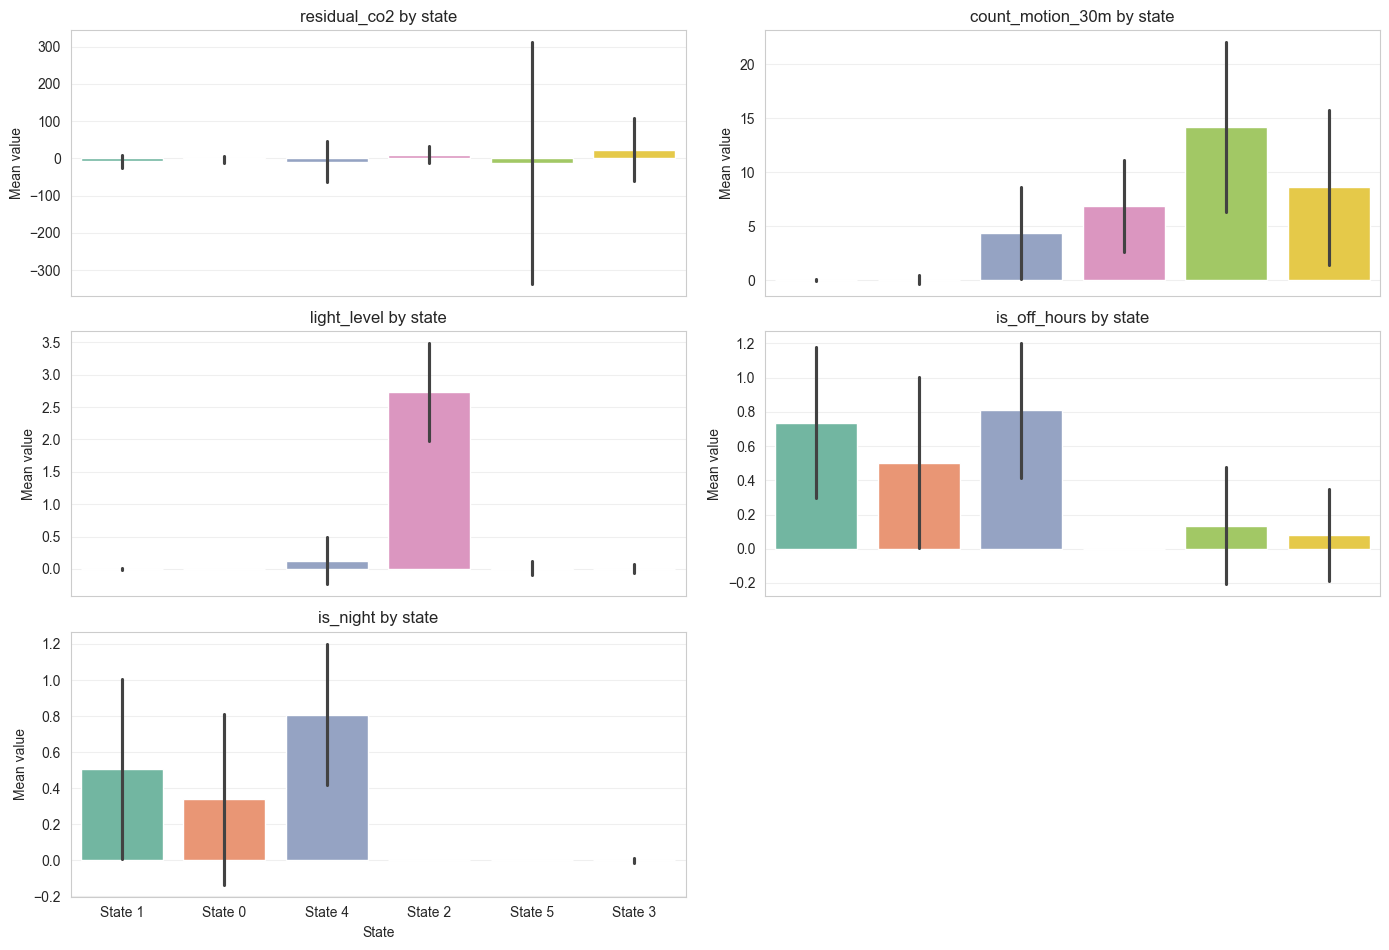

In [19]:
profile_features = [
    'residual_co2', 'count_motion_30m',
    'light_level', 'is_off_hours', 'is_night'
]
present_features = [feat for feat in profile_features if feat in df.columns]
ordered_labels = [state_label_map[state] for state in ordered_states]

if not present_features:
    raise ValueError("No profile features available for plotting.")

summary = (
    df.groupby('state_label')[present_features]
    .agg(['mean', 'std'])
    .round(2)
)
print("Per-state feature means ± std:")
display(summary)

n_features = len(present_features)
n_cols = 2
n_rows = int(np.ceil(n_features / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3.2 * n_rows), sharex=True)
axes = np.array(axes).reshape(-1)

for idx, feature in enumerate(present_features):
    ax = axes[idx]
    sns.barplot(
        data=df,
        x='state_label',
        y=feature,
        order=ordered_labels,
        hue='state_label',
        hue_order=ordered_labels,
        palette=state_color_map,
        ax=ax,
        errorbar='sd',
        legend=False
    )
    ax.set_title(f'{feature} by state')
    ax.set_xlabel('State')
    ax.set_ylabel('Mean value')
    ax.grid(axis='y', alpha=0.3)

for ax in axes[len(present_features):]:
    ax.remove()

plt.tight_layout()
plt.show()

## Feature Distributions by State

/var/folders/nx/8zsks9g56_l5b71b062pyqw00000gn/T/ipykernel_66348/2668965150.py:14: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


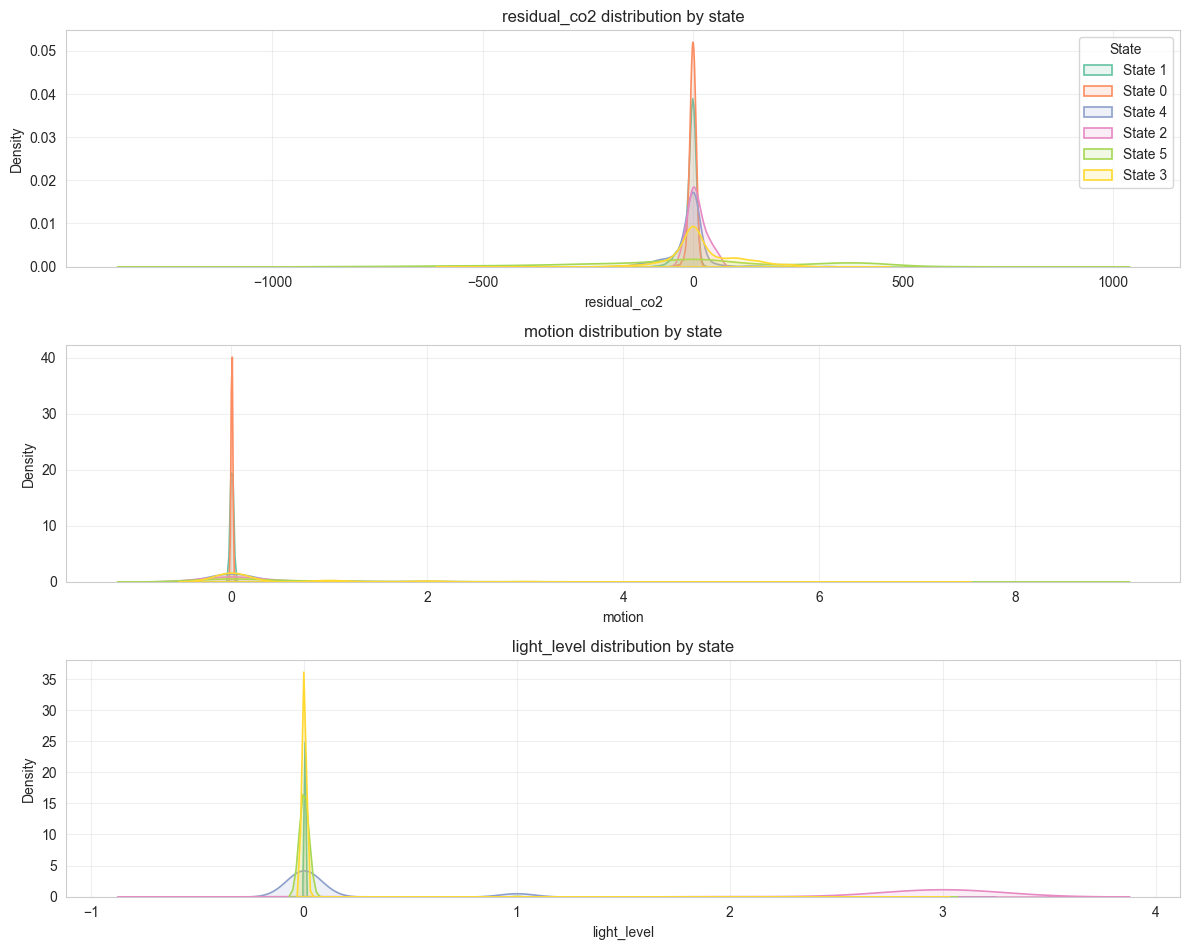

In [10]:
distribution_features = [
    'residual_co2', 'motion', 'light_level'
]
distribution_features = [feat for feat in distribution_features if feat in df.columns]
num_states = len(ordered_labels)

if distribution_features:
    fig, axes = plt.subplots(len(distribution_features), 1, figsize=(12, 3.2 * len(distribution_features)), sharex=False)
    if len(distribution_features) == 1:
        axes = [axes]

    for feature, ax in zip(distribution_features, axes):
        for label in ordered_labels:
            sns.kdeplot(
                data=df[df['state_label'] == label],
                x=feature,
                fill=True,
                alpha=0.15,
                linewidth=1.2,
                color=state_color_map[label],
                label=label if feature == distribution_features[0] else None,
                ax=ax
            )
        ax.set_title(f'{feature} distribution by state')
        ax.grid(True, alpha=0.3)
    if ordered_labels:
        axes[0].legend(title='State')
    plt.tight_layout()
    plt.show()
else:
    print("No continuous features available for distribution plots.")

## Low-Dimensional Embedding Colored by State

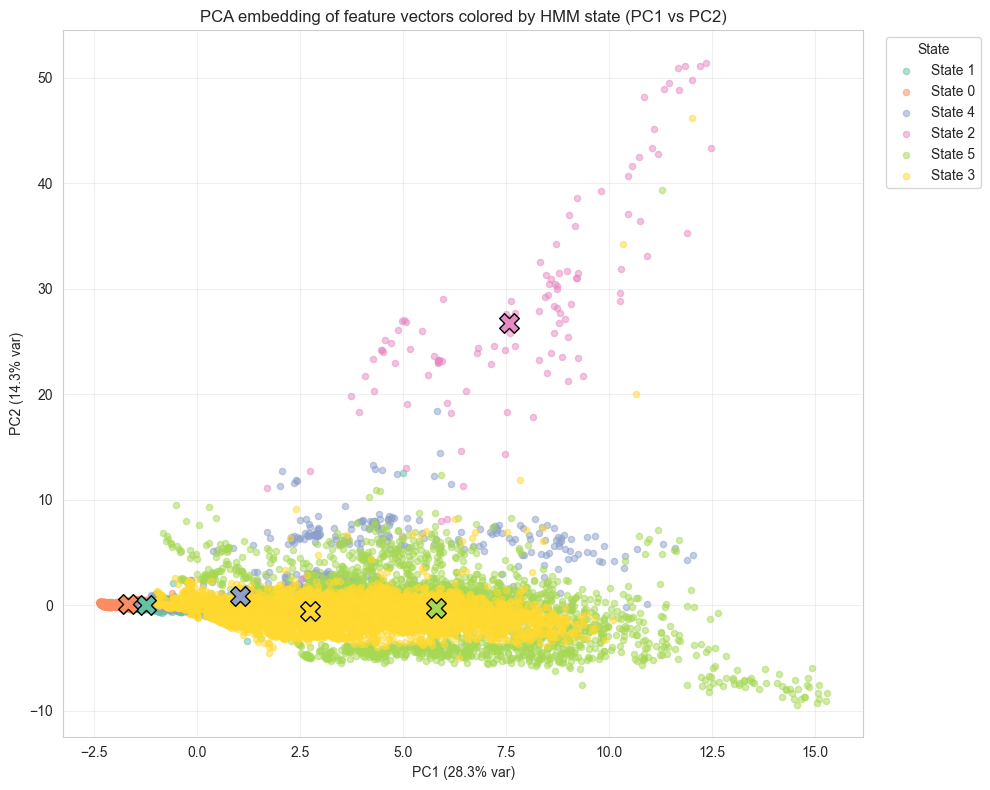

In [11]:
pca = PCA(n_components=3, random_state=42)
pca_embedding = pca.fit_transform(X_scaled)
embedding_df = pd.DataFrame(pca_embedding, columns=['PC1', 'PC2', 'PC3'])
embedding_df['state_label'] = df['state_label'].values

# 2D scatter for quick overview
fig, ax = plt.subplots(figsize=(10, 8))
for label in ordered_labels:
    subset = embedding_df[embedding_df['state_label'] == label]
    ax.scatter(
        subset['PC1'],
        subset['PC2'],
        s=20,
        alpha=0.5,
        color=state_color_map[label],
        label=label
    )

centroids = []
for state in ordered_states:
    label = state_label_map[state]
    mask = embedding_df['state_label'] == label
    if mask.any():
        centroids.append({
            'label': label,
            'PC1': embedding_df.loc[mask, 'PC1'].mean(),
            'PC2': embedding_df.loc[mask, 'PC2'].mean(),
            'PC3': embedding_df.loc[mask, 'PC3'].mean()
        })
        ax.scatter(
            centroids[-1]['PC1'],
            centroids[-1]['PC2'],
            s=200,
            color=state_color_map[label],
            edgecolor='black',
            marker='X'
        )

ax.set_title('PCA embedding of feature vectors colored by HMM state (PC1 vs PC2)')
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
ax.legend(title='State', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Temporal State Views

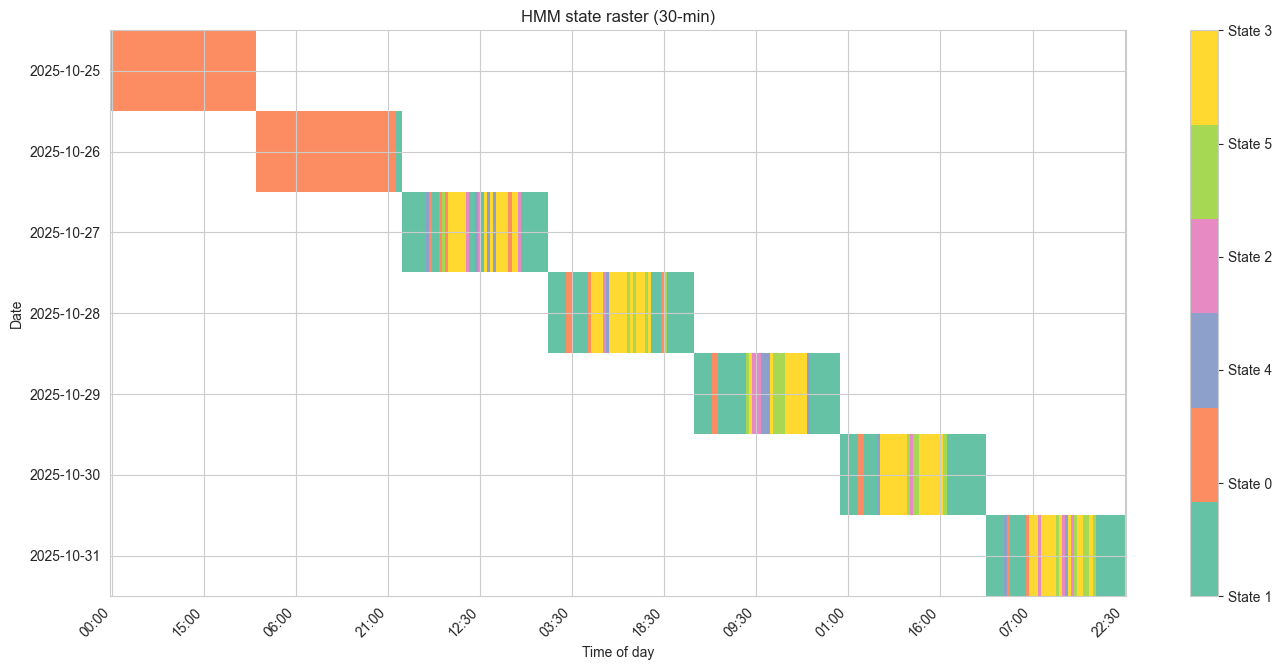

In [12]:
# Daily raster of states (latest 7 days)
raster_df = df[['timestamp', 'hmm_state', 'state_label']].copy()
raster_df['date'] = raster_df['timestamp'].dt.date
raster_df['time_bin'] = raster_df['timestamp'].dt.floor('30min')
state_to_idx = {state: idx for idx, state in enumerate(ordered_states)}
raster_df['state_idx'] = raster_df['hmm_state'].map(state_to_idx)

unique_dates = sorted(raster_df['date'].unique())
show_dates = unique_dates[-7:] if len(unique_dates) > 7 else unique_dates
subset = raster_df[raster_df['date'].isin(show_dates)]
if subset.empty:
    print("Not enough data for temporal raster.")
else:
    pivot = subset.pivot_table(
        index='date',
        columns='time_bin',
        values='state_idx',
        aggfunc='mean'
    ).sort_index()

    cmap = ListedColormap([state_color_map[state_label_map[state]] for state in ordered_states])
    fig, ax = plt.subplots(figsize=(14, 4 + 0.4 * len(pivot)))
    cax = ax.imshow(pivot.values, aspect='auto', cmap=cmap, interpolation='nearest')
    ax.set_yticks(np.arange(len(pivot.index)))
    ax.set_yticklabels([date.strftime('%Y-%m-%d') for date in pivot.index])
    ax.set_xticks(np.linspace(0, pivot.shape[1]-1, min(12, pivot.shape[1])))
    xlabels = [pivot.columns[int(idx)].strftime('%H:%M') for idx in ax.get_xticks().astype(int)]
    ax.set_xticklabels(xlabels, rotation=45, ha='right')
    ax.set_title('HMM state raster (30-min)')
    ax.set_xlabel('Time of day')
    ax.set_ylabel('Date')

    colorbar = fig.colorbar(cax, ticks=range(len(ordered_states)))
    colorbar.ax.set_yticklabels([state_label_map[state] for state in ordered_states])
    plt.tight_layout()
    plt.show()

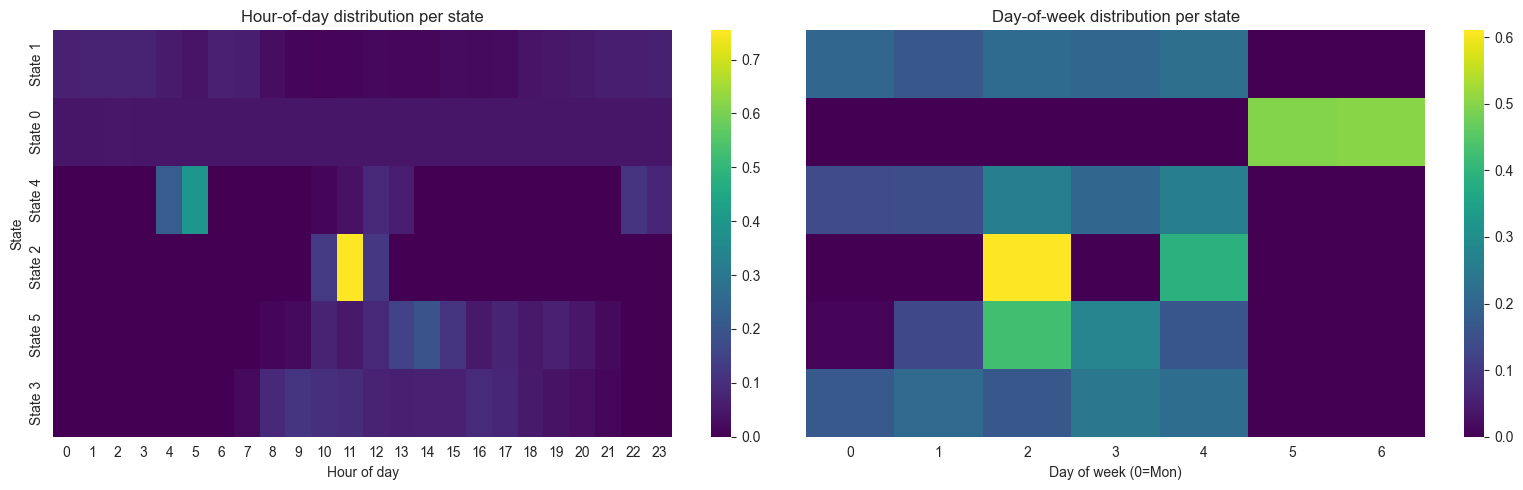

In [13]:
# Hour-of-day and day-of-week distributions per state
if {'hour_of_day', 'day_of_week'}.issubset(df.columns):
    hour_matrix = (
        df.groupby(['state_label', 'hour_of_day']).size()
        .unstack(fill_value=0)
    )
    hour_matrix = hour_matrix.div(hour_matrix.sum(axis=1), axis=0)

    dow_matrix = (
        df.groupby(['state_label', 'day_of_week']).size()
        .unstack(fill_value=0)
    )
    dow_matrix = dow_matrix.div(dow_matrix.sum(axis=1), axis=0)

    fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
    sns.heatmap(hour_matrix.loc[ordered_labels], ax=axes[0], cmap='viridis')
    axes[0].set_title('Hour-of-day distribution per state')
    axes[0].set_xlabel('Hour of day')
    axes[0].set_ylabel('State')

    sns.heatmap(dow_matrix.loc[ordered_labels], ax=axes[1], cmap='viridis')
    axes[1].set_title('Day-of-week distribution per state')
    axes[1].set_xlabel('Day of week (0=Mon)')
    axes[1].set_ylabel('')
    plt.tight_layout()
    plt.show()
else:
    print("Columns hour_of_day/day_of_week missing; skipping temporal histograms.")

## Transition & Joint Sensor Behavior

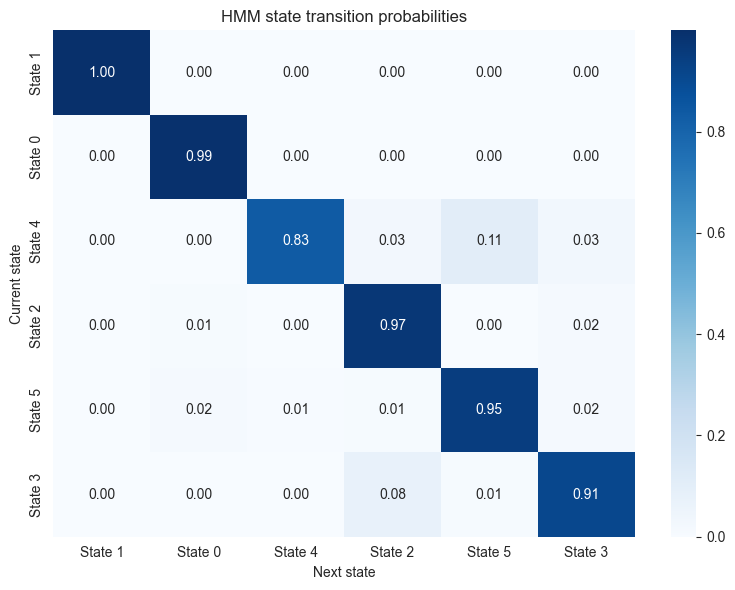

In [14]:
# Transition matrix heatmap
trans_df = pd.DataFrame(
    hmm.transmat_,
    index=[state_label_map[state] for state in ordered_states],
    columns=[state_label_map[state] for state in ordered_states],
)
plt.figure(figsize=(8, 6))
sns.heatmap(trans_df, annot=True, fmt=".2f", cmap="Blues")
plt.title("HMM state transition probabilities")
plt.xlabel("Next state")
plt.ylabel("Current state")
plt.tight_layout()
plt.show()

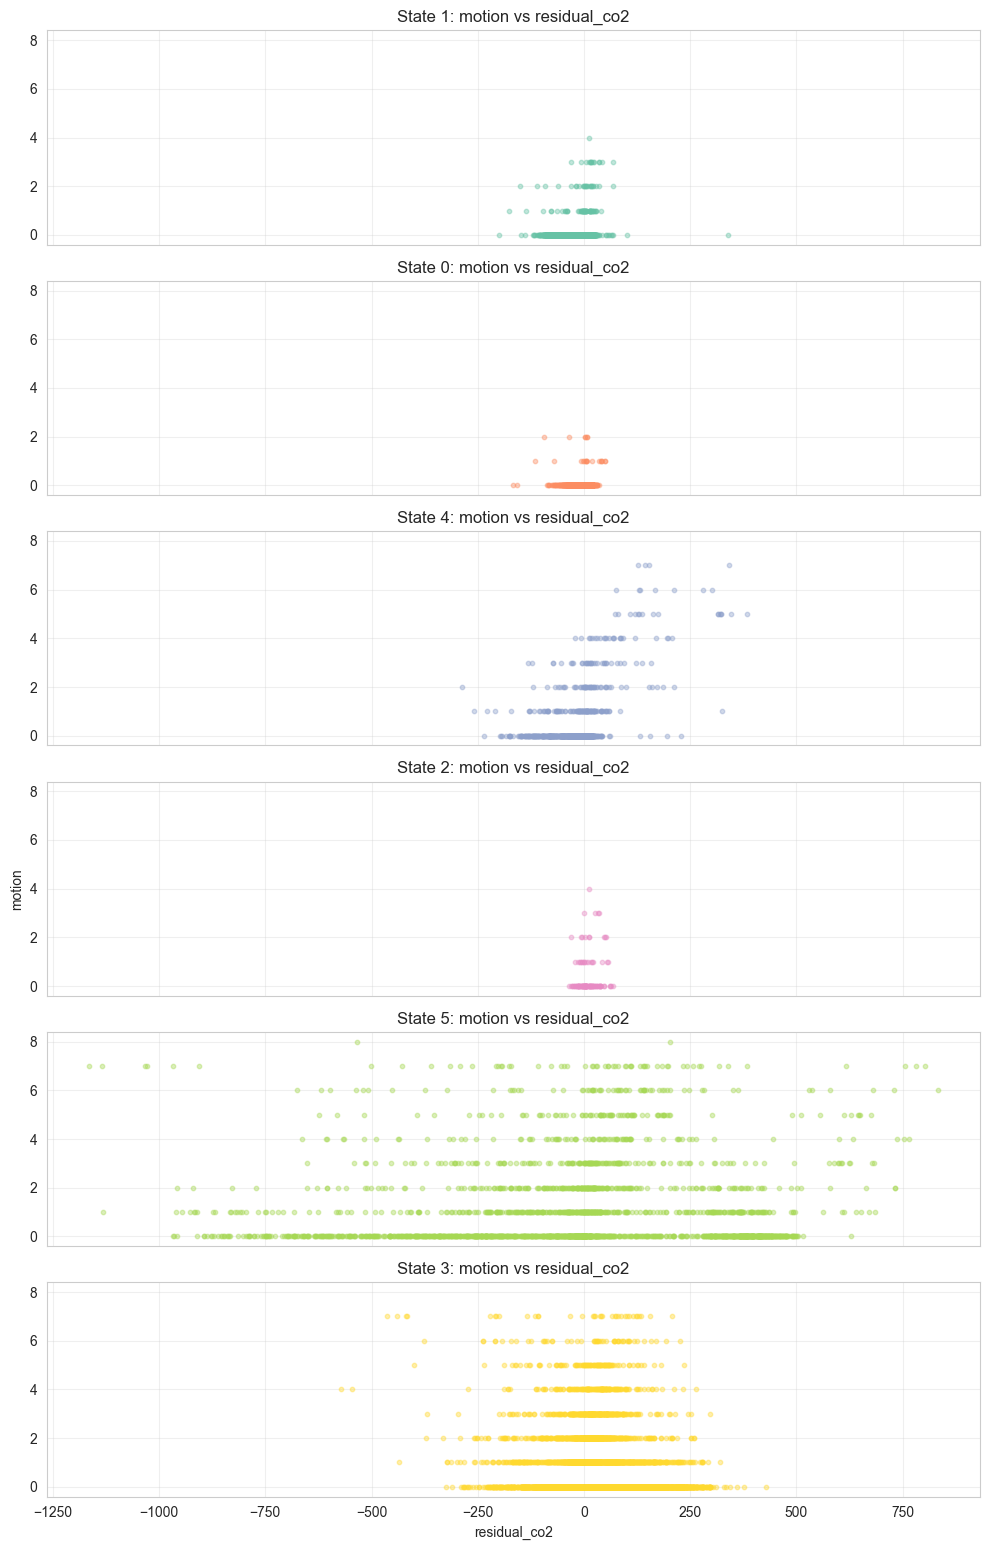

In [15]:
# Joint residual CO2 vs motion scatter
joint_x, joint_y = "residual_co2", "motion"
if {joint_x, joint_y}.issubset(df.columns):
    fig, axes = plt.subplots(
        len(ordered_labels),
        1,
        figsize=(10, 2.6 * len(ordered_labels)),
        sharex=True,
        sharey=True,
    )
    if len(ordered_labels) == 1:
        axes = [axes]
    for ax, label in zip(axes, ordered_labels):
        subset = df[df["state_label"] == label]
        ax.scatter(
            subset[joint_x],
            subset[joint_y],
            s=10,
            alpha=0.4,
            color=state_color_map[label],
        )
        ax.set_title(f"{label}: {joint_y} vs {joint_x}")
        ax.grid(True, alpha=0.3)
    axes[-1].set_xlabel(joint_x)
    axes[len(axes) // 2].set_ylabel(joint_y)
    plt.tight_layout()
    plt.show()
else:
    print("Residual CO₂ or motion column missing; skipping joint scatter.")

## Weekly CO2 Rise with Occupancy Shading

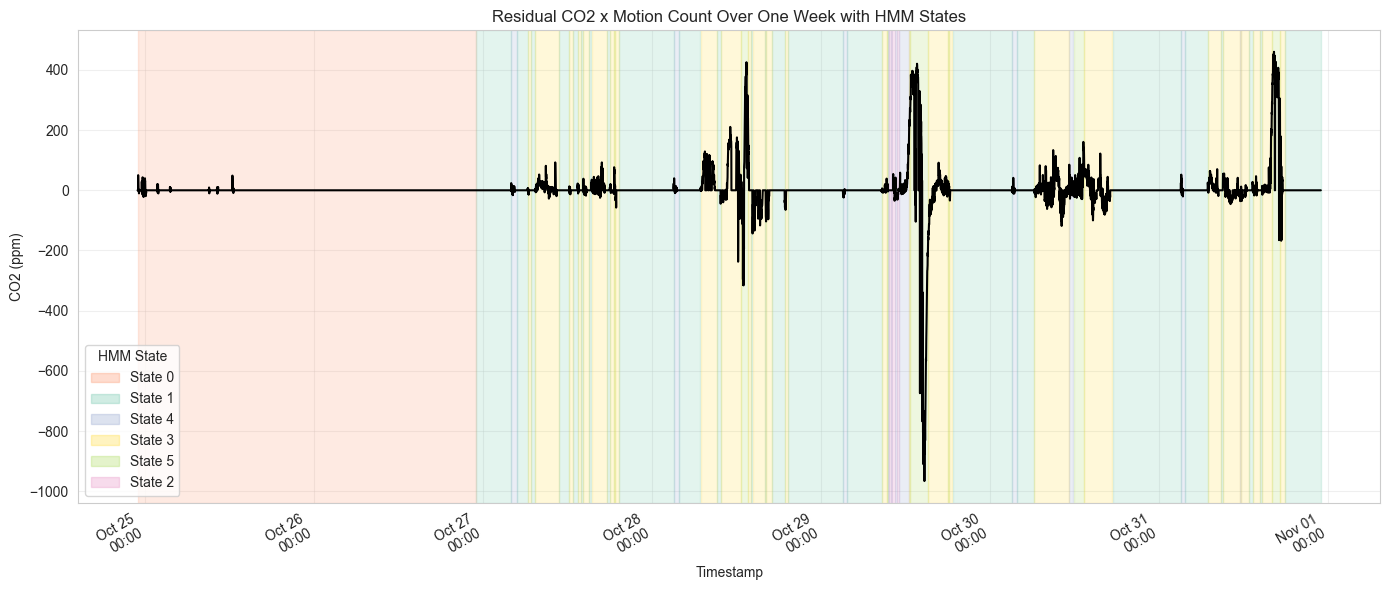

Window shown: 2025-10-24 22:58:35 → 2025-10-31 22:58:35 (7 days 00:00:00)


In [ ]:
if df.empty:
    raise ValueError("Dataframe is empty; cannot plot CO₂ trend.")

window = pd.Timedelta(days=7)
full_range = df['timestamp'].max() - df['timestamp'].min()
if full_range <= window:
    week_start = df['timestamp'].min()
    week_end = df['timestamp'].max()
else:
    week_end = df['timestamp'].max()
    week_start = week_end - window

week_df = df[(df['timestamp'] >= week_start) & (df['timestamp'] <= week_end)].copy()
if week_df.empty:
    week_df = df.copy()
    week_start, week_end = week_df['timestamp'].min(), week_df['timestamp'].max()

week_df = week_df.sort_values('timestamp').reset_index(drop=True)

if 'state_label' not in week_df.columns:
    raise ValueError("Missing `state_label`. Run the state interpretation cell first.")

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(week_df['timestamp'], week_df['residual_co2_recent_motion'], color='black', linewidth=1.5, label='CO2 (ppm)')
ax.set_title('Residual CO2 x Motion Count Over One Week with HMM States')
ax.set_ylabel('CO2 (ppm) x Motion Count')
ax.set_xlabel('Timestamp')
ax.grid(True, alpha=0.3)

labels_seen = []
segment_label = None
segment_start = None
prev_ts = None

for ts, label in zip(week_df['timestamp'], week_df['state_label']):
    if pd.isna(label):
        prev_ts = ts
        continue
    if segment_label is None:
        segment_label = label
        segment_start = ts
    elif label != segment_label and prev_ts is not None:
        color = state_color_map.get(segment_label, '#bdc3c7')
        ax.axvspan(segment_start, prev_ts, color=color, alpha=0.18,
                   label=segment_label if segment_label not in labels_seen else None)
        if segment_label not in labels_seen:
            labels_seen.append(segment_label)
        segment_label = label
        segment_start = ts
    prev_ts = ts

if segment_label is not None and prev_ts is not None:
    color = state_color_map.get(segment_label, '#bdc3c7')
    ax.axvspan(segment_start, prev_ts, color=color, alpha=0.18,
               label=segment_label if segment_label not in labels_seen else None)
    if segment_label not in labels_seen:
        labels_seen.append(segment_label)

if labels_seen:
    legend_handles = [
        plt.Rectangle((0, 0), 1, 1, color=state_color_map.get(label, '#bdc3c7'), alpha=0.3)
        for label in labels_seen
    ]
    ax.legend(legend_handles, labels_seen, title='HMM State')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d\n%H:%M'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

print(f"Window shown: {week_start} → {week_end} ({(week_end - week_start)})")

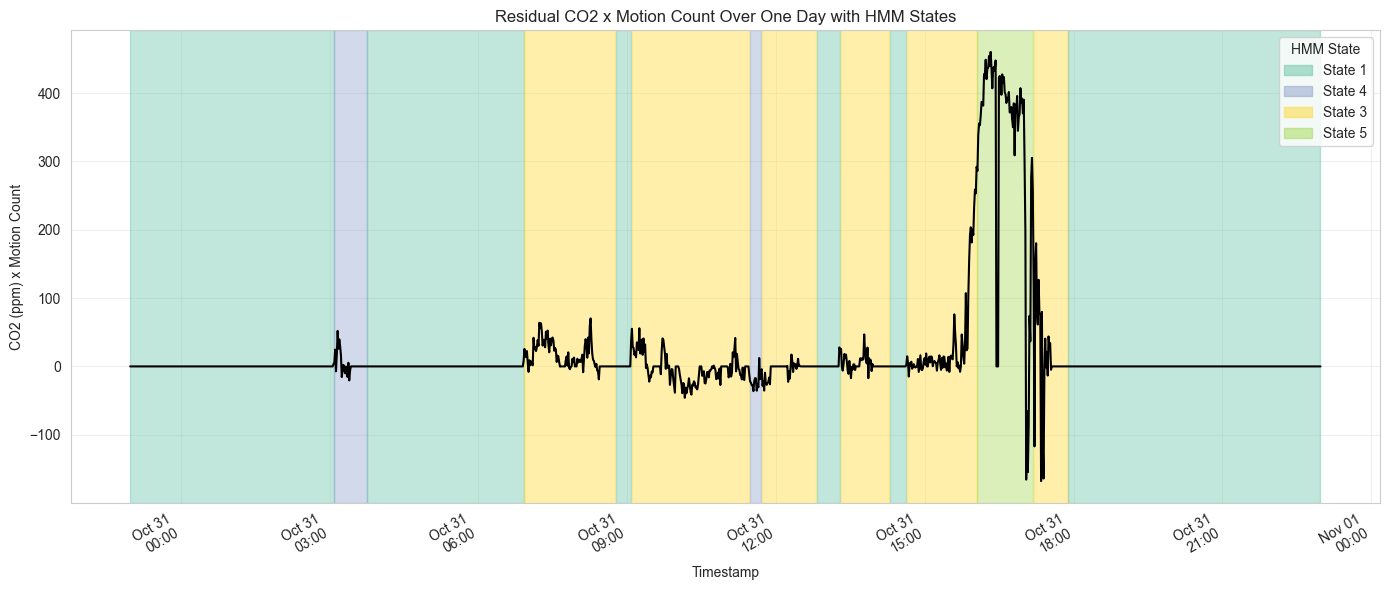

Window shown: 2025-10-30 22:58:35 -> 2025-10-31 22:58:35 (1 days 00:00:00)


In [20]:
if df.empty:
    raise ValueError("Dataframe is empty; cannot plot CO₂ trend.")

window = pd.Timedelta(days=1)
full_range = df['timestamp'].max() - df['timestamp'].min()
if full_range <= window:
    week_start = df['timestamp'].min()
    week_end = df['timestamp'].max()
else:
    week_end = df['timestamp'].max()
    week_start = week_end - window

week_df = df[(df['timestamp'] >= week_start) & (df['timestamp'] <= week_end)].copy()
if week_df.empty:
    week_df = df.copy()
    week_start, week_end = week_df['timestamp'].min(), week_df['timestamp'].max()

week_df = week_df.sort_values('timestamp').reset_index(drop=True)

if 'state_label' not in week_df.columns:
    raise ValueError("Missing `state_label`. Run the state interpretation cell first.")

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(week_df['timestamp'], week_df['residual_co2_recent_motion'], color='black', linewidth=1.5, label='CO₂ (ppm)')
ax.set_title('Residual CO2 x Motion Count Over One Day with HMM States')
ax.set_ylabel('CO2 (ppm) x Motion Count')
ax.set_xlabel('Timestamp')
ax.grid(True, alpha=0.3)

labels_seen = []
segment_label = None
segment_start = None
prev_ts = None

for ts, label in zip(week_df['timestamp'], week_df['state_label']):
    if pd.isna(label):
        prev_ts = ts
        continue
    if segment_label is None:
        segment_label = label
        segment_start = ts
    elif label != segment_label and prev_ts is not None:
        color = state_color_map.get(segment_label, "#616466")
        ax.axvspan(segment_start, prev_ts, color=color, alpha=0.4,
                   label=segment_label if segment_label not in labels_seen else None)
        if segment_label not in labels_seen:
            labels_seen.append(segment_label)
        segment_label = label
        segment_start = ts
    prev_ts = ts

if segment_label is not None and prev_ts is not None:
    color = state_color_map.get(segment_label, "#9b9b9b")
    ax.axvspan(segment_start, prev_ts, color=color, alpha=0.4,
               label=segment_label if segment_label not in labels_seen else None)
    if segment_label not in labels_seen:
        labels_seen.append(segment_label)

if labels_seen:
    legend_handles = [
        plt.Rectangle((0, 0), 1, 1, color=state_color_map.get(label, '#bdc3c7'), alpha=0.5)
        for label in labels_seen
    ]
    ax.legend(legend_handles, labels_seen, title='HMM State')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d\n%H:%M'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

print(f"Window shown: {week_start} -> {week_end} ({(week_end - week_start)})")

## Persist HMM Artifacts

In [18]:
# Save the trained HMM, scaler, and state metadata for deployment
folder = 'model'
os.makedirs(folder, exist_ok=True)

artifacts = {
    'model_path': f'{folder}/hmm_occupancy_model.pkl',
    'scaler_path': f'{folder}/hmm_scaler.pkl',
    'state_label_path': f'{folder}/hmm_state_labels.pkl'
}



with open(artifacts['model_path'], 'wb') as f:
    pickle.dump(hmm, f)
print(f"Saved Gaussian HMM: {artifacts['model_path']}")

with open(artifacts['scaler_path'], 'wb') as f:
    pickle.dump(scaler, f)
print(f"Saved StandardScaler: {artifacts['scaler_path']}")

with open(artifacts['state_label_path'], 'wb') as f:
    pickle.dump({'state_label_map': state_label_map, 'state_color_map': state_color_map}, f)
print(f"Saved state label metadata: {artifacts['state_label_path']}")

config = {
    'selected_n_states': n_states,
    'candidate_states': candidate_states,
    'stickiness': final_stickiness,
    'smoothing_window': smoothing_window,
    'feature_cols': feature_cols,
    'interpretation_features': available_features,
    'covariance_type': 'diag',
    'state_label_map': state_label_map,
    'state_color_map': state_color_map
}
with open(f'{folder}/hmm_config.pkl', 'wb') as f:
    pickle.dump(config, f)
print(f"Saved configuration: {folder}/hmm_config.pkl")

Saved Gaussian HMM: model/hmm_occupancy_model.pkl
Saved StandardScaler: model/hmm_scaler.pkl
Saved state label metadata: model/hmm_state_labels.pkl
Saved configuration: model/hmm_config.pkl
